In [1]:
import os
import sys
# os.environ["BACKEND"] = "numpy"
script_dir      = os.path.dirname(os.curdir)
parent_dir      = os.path.abspath(os.path.join(script_dir, '..'))
parent_dir_up   = os.path.abspath(os.path.join(parent_dir, '..'))
if parent_dir_up not in sys.path:
    sys.path.append(parent_dir_up)

from QES.Algebra.Model.Noninteracting.Conserving.free_fermions import FreeFermions
import numpy as np

/Users/makskliczkowski/Codes/QuantumEigenSolver/Python/Projects
/Users/makskliczkowski/Codes/QuantumEigenSolver/Python


INFO:general_python.algebra.utils:63: JAX backend available and successfully imported
INFO:general_python.algebra.utils:63: 	JAX 64-bit precision enabled.
INFO:general_python.algebra.utils:63: 	JAX is available but not set as the active backend.
INFO:general_python.algebra.utils:63: **************************************************
INFO:general_python.algebra.utils:63: Backend Configuration:
INFO:general_python.algebra.utils:63: 		NumPy Version: 2.1.3
INFO:general_python.algebra.utils:63: 		SciPy Version: 1.15.2
INFO:general_python.algebra.utils:63: 		JAX Version: 0.5.3
INFO:general_python.algebra.utils:63: 		Active Backend: numpy
INFO:general_python.algebra.utils:63: 			JAX Available: True
INFO:general_python.algebra.utils:63: 			Default Seed: 42
INFO:general_python.algebra.utils:63: 		NumPy Backend Details:
INFO:general_python.algebra.utils:63: 				Main Module: numpy
INFO:general_python.algebra.utils:63: 				Random Module: Generator
INFO:general_python.algebra.utils:63: 				SciPy Mo

In [13]:
ns      = 12
t       = 1.0
backend = 'numpy'
hamil   = FreeFermions(ns=ns, t = t, dtype = np.complex128, backend = backend, logger=None)
hamil

FreeFermions(ns=12, t=1.0, constant_offset=0.0)

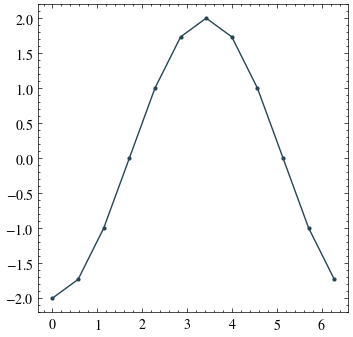

In [14]:
from general_python.common.plot import Plotter

fig, ax = Plotter.get_subplots(1, 1, sizex=4, sizey=4)
k       = np.linspace(0, 2 * np.pi, hamil.ns)
ax[0].plot(k, hamil.eig_val, '-o', markersize=2)

In [15]:
from scipy.special import comb
from itertools import combinations

def n_choose(n, k):
    return comb(n, k)

n_particles = 3
arange      = list(range(hamil.ns))
orbitals    = np.random.choice(arange, n_particles)
energies    = []
ns          = hamil.ns
nh          = 0
for i in range(ns + 1):
    # go through all the orbitals combinations
    n_elements = int(n_choose(ns, i))
    print(f"n_elements: {n_elements}")
    
    all_combinations = list(combinations(arange, i))
    
    if len(all_combinations) == 0:
        continue
    print(f"\tall_combinations: {len(all_combinations)}")
    
    for j in range(n_elements):
        orbitals    = np.array(all_combinations[j])
        energy      = hamil.many_body_energy(orbitals)
        energies.append(energy)
    # add
    nh += n_elements
print(f"nh: {nh}")

n_elements: 1
	all_combinations: 1
n_elements: 12
	all_combinations: 12
n_elements: 66
	all_combinations: 66
n_elements: 220
	all_combinations: 220
n_elements: 495
	all_combinations: 495
n_elements: 792
	all_combinations: 792
n_elements: 924
	all_combinations: 924
n_elements: 792
	all_combinations: 792
n_elements: 495
	all_combinations: 495
n_elements: 220
	all_combinations: 220
n_elements: 66
	all_combinations: 66
n_elements: 12
	all_combinations: 12
n_elements: 1
	all_combinations: 1
nh: 4096


np.float64(-7.4641016151377535)

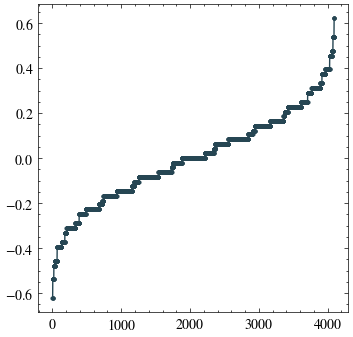

In [16]:
fig, ax     = Plotter.get_subplots(1, 1, sizex=4, sizey=4)
energies    = np.sort(energies)
ax[0].plot(energies / ns, '-o', markersize=2)

energies[0]

In [19]:
energies_sp     = hamil.eig_val
energies_sp_neg = energies_sp[energies_sp < 0]
ground_state_occ= len(energies_sp_neg)
ground_state    = np.sum(energies_sp_neg)
ground_state, ground_state_occ

(np.float64(-7.4641016151377535), 6)